# Download Datasets

In [1]:
from dataset_downloader import DatasetDownloader
dataset_downloader = DatasetDownloader()

#------------------------------------------------
# Remove the commenting below to download the dataset
#------------------------------------------------

#dataset_downloader.download_datasets("download_paths_2025.yaml")

# Libraries and Hyper Parameters

In [2]:
import matplotlib.pyplot as plt
import yaml
import numpy as np
import librosa

In [3]:
def load_hyper_parameters():
    with open("hyper_parameters.yaml", 'r') as file:
        return yaml.safe_load(file)

In [4]:
hyper_parameters = load_hyper_parameters()

#> Acoustic Features
acoustic_features = hyper_parameters['acoustic_features']
number_of_mels = acoustic_features['number_of_mels']
number_of_frames_to_concatenate = acoustic_features['number_of_frames_to_concatenate']
frame_size_seconds = acoustic_features['frame_size_seconds']
frame_size_samples = acoustic_features['frame_size_samples']
hop_size_seconds = acoustic_features['hop_size_seconds']
hop_size_samples = acoustic_features['hop_size_samples']


#> Dataset Parameters
dataset_paremeters = hyper_parameters['dataset_parameters']
train_data_inclusion_string = dataset_paremeters['train_data_inclusion_string']
test_data_inclusion_string = dataset_paremeters['test_data_inclusion_string']
train_pct = dataset_paremeters['train_pct']
test_pct = dataset_paremeters['test_pct']


#> Training Parameters
training_parameters = hyper_parameters['training_parameters']
batch_size = training_parameters['batch_size']
epochs = training_parameters['epochs']
learning_rate = training_parameters['learning_rate']
shuffle = training_parameters['shuffle']

# Load Dataset

In [5]:
from data_bundler import DataBundler

data_bundler = DataBundler()
clip_lengths, training_data, training_filenames = data_bundler.load_dataset(train_data_inclusion_string, train_pct)
number_of_training_data = len(training_data)

Audio Converter Here!

Data Loader Here!
Audio Converter Here!


Processing audio files: 100%|██████████| 700/700 [00:16<00:00, 42.05file/s]


Done loading!
Length of dataset: 45974



# Training Autoencoder

In [6]:
!nvidia-smi

Wed May 14 04:55:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| 56%   34C    P8             10W /   75W |    1270MiB /   4096MiB |     28%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

In [8]:
import torch
import torch.nn as nn
import torch.optim as optimizer
from autoencoder import Autoencoder
from torch.utils.data import DataLoader

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1650
Using device: cuda:0


In [10]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
my_optimizer = optimizer.Adam(model.parameters(), lr=learning_rate)
number_of_epochs = epochs

In [66]:
dataset = torch.tensor(training_data, dtype=torch.float32)
input_features = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
len(input_features)

180

In [67]:
import time

training_losses = []
start_time = time.time()

def train_model():
    #> loop through the number of epochs
    for epoch in range(number_of_epochs):
        model.train() #set the model to training mode
        total_loss = 0 #reset the total loss for this epoch

        #> loop through the training data
        for data in input_features:
            input = data.to(device) #move the data to the device (GPU or CPU)
            my_optimizer.zero_grad() #reset the gradients of the optimizer

            #> forward pass
            output = model(input) #pass the data through the model
            loss = criterion(output, input) #calculate the loss by comparing the output to the input data

            #> backward pass
            loss.backward() #compute gradients for all parameters
            my_optimizer.step() #update the model parameters based on the gradients
            total_loss += loss.item() #accumulate the loss for this batch

        average_loss = total_loss / len(input_features)
        training_losses.append(average_loss)

        elapsed_time = time.time() - start_time
        print(f"Epoch [{epoch + 1}/{number_of_epochs}] ({elapsed_time:.2f}s) - Loss: {average_loss:.4f}")

    model.eval()

In [65]:
train_model()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x256 and 640x128)

In [14]:
# torch.save(model.state_dict(), 'model.pth')

# Training Results

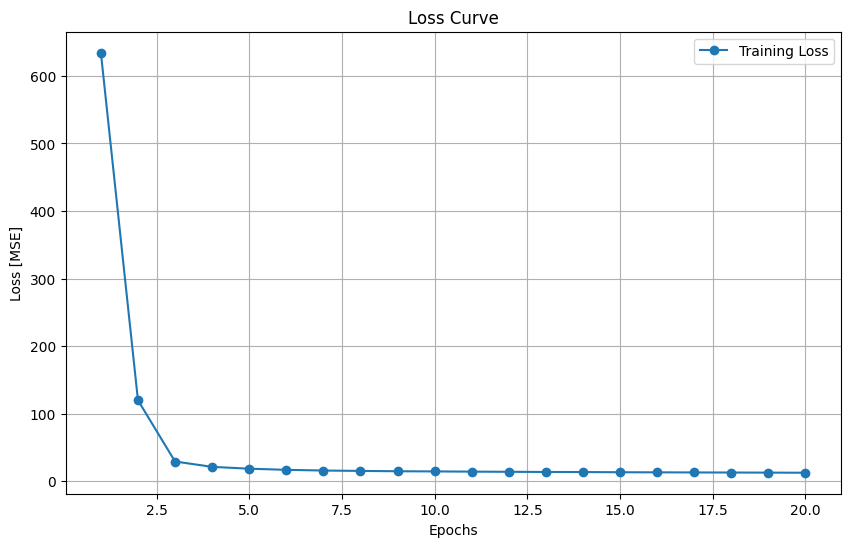

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss [MSE]')
plt.legend()
plt.grid()
plt.show()

## Load Evaluation Dataset

In [36]:
from data_bundler import DataBundler

data_bundler = DataBundler()
#test_original_mel = data_bundler.load_dataset(test_data_inclusion_string, test_pct, False, False)
clip_lengths, testing_data, testing_filenames = data_bundler.load_dataset(test_data_inclusion_string, test_pct, True, True, "all")
number_of_testing_data = len(testing_data)


Data Loader Here!
Audio Converter Here!


Processing audio files: 100%|██████████| 140/140 [00:03<00:00, 42.56file/s]


Done loading!
Length of dataset: 9174



In [37]:
original_clips = []

start_index = 0

for size in clip_lengths:
    end_index = start_index + size
    original_clips.append(testing_data[start_index:end_index])
    start_index = end_index

In [38]:
import re

status_list = []
pattern = r"_(normal|anomaly)_"

for line in testing_filenames:
    match = re.search(pattern, line)
    if match:
        status_list.append(match.group(1))

# print(len(status_list))
# status_list

## Evaluation

In [39]:
dataset = torch.tensor(testing_data, dtype=torch.float32)
input_features = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [40]:
from torch.nn.functional import mse_loss

mse_list = []
output_features = []


def evaluate_model(input_features, model):
    model.eval()
    total_mse = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in input_features:
            input = data.to(device)
            output = model(input)

            output_features.append(output.cpu().numpy())  # Store the reconstruction for later use

            mse = mse_loss(output, input, reduction='sum').item()
            mse_list.append(mse)
            total_mse += mse
            total_samples += input.numel()
            

    average_mse = total_mse / total_samples
    return average_mse

mse = evaluate_model(input_features, model)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Mean Squared Error on Test Set: 13.4296


In [41]:
output_features = np.vstack(output_features)

In [42]:
print(np.mean((output_features - testing_data)**2))
print(np.mean(np.abs(output_features - testing_data)))

112.23731
8.13996


In [43]:
reconstructed_clips = []
start_index = 0

for size in clip_lengths:
    end_index = start_index + size
    reconstructed_clips.append(output_features[start_index:end_index])
    start_index = end_index

In [44]:
recon_err_per_clip = []
for i in range(len(reconstructed_clips)):
    item1 = reconstructed_clips[i].reshape(-1)
    item2 = original_clips[i].reshape(-1)
    
    recon_err_per_clip.append(np.mean((item1 - item2)**2))

recon_err_per_clip
print(item1)
print(item2)
print(item1 - item2)
print(np.mean((item1 - item2)**2))
print("\n")
print(recon_err_per_clip)

[-11.902238 -11.916105 -11.879062 ... -51.522106 -51.63205  -51.687313]
[-14.0708     -8.2806015 -13.829286  ... -44.45818   -48.999523
 -45.089977 ]
[ 2.168562  -3.6355038  1.9502239 ... -7.0639267 -2.6325264 -6.597336 ]
83.5741


[np.float32(105.26979), np.float32(121.8721), np.float32(76.039215), np.float32(130.34885), np.float32(98.08307), np.float32(86.27609), np.float32(127.48843), np.float32(88.98983), np.float32(106.54278), np.float32(76.883415), np.float32(339.90494), np.float32(65.251755), np.float32(112.89805), np.float32(250.88567), np.float32(89.01759), np.float32(101.623825), np.float32(113.215576), np.float32(97.74135), np.float32(83.66672), np.float32(82.32748), np.float32(126.81274), np.float32(111.39961), np.float32(71.32203), np.float32(155.44972), np.float32(129.21854), np.float32(86.60527), np.float32(86.282104), np.float32(114.98124), np.float32(336.07635), np.float32(117.528625), np.float32(89.07843), np.float32(79.08157), np.float32(127.05197), np.float32(62.161

In [45]:
from scipy.stats import gamma

shape, loc, scale = gamma.fit(recon_err_per_clip)

anomaly_threshold = gamma.ppf(0.9, shape, loc=loc, scale=scale)
anomaly_threshold

np.float64(56.036127514650175)

56.036127514650175


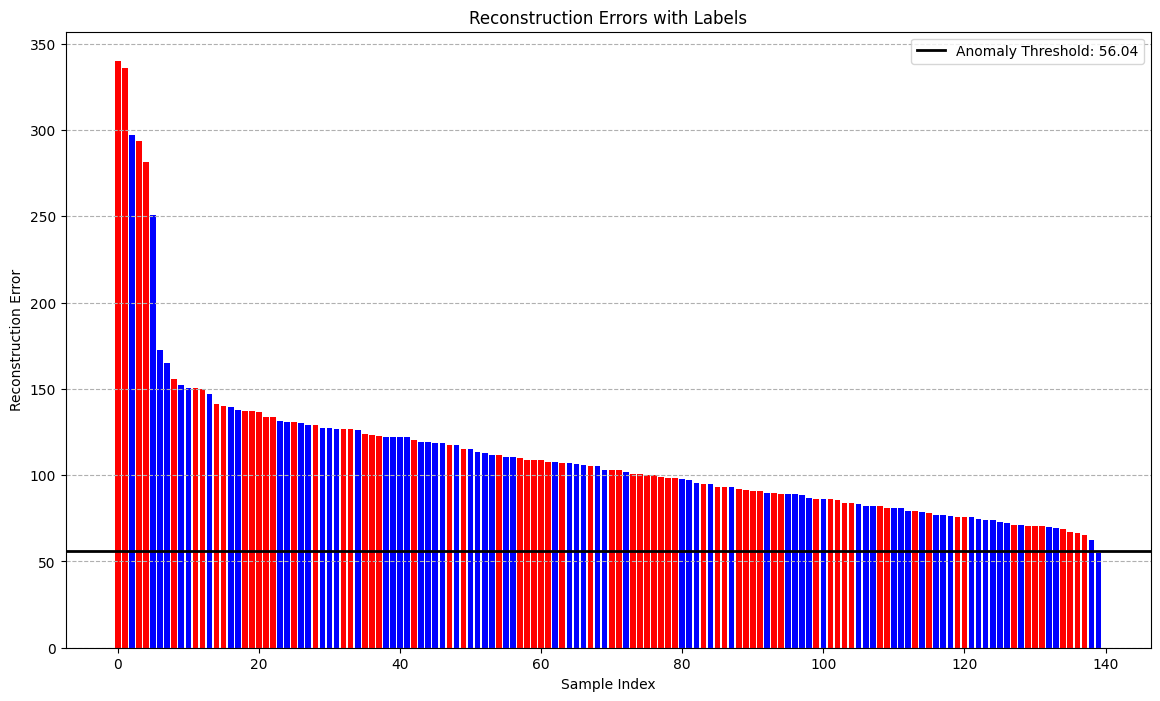

In [57]:
merged = list(zip(status_list, recon_err_per_clip))
# merged

sorted_means = sorted(merged, key=lambda x: x[1], reverse=True)

# Separate the data
labels, values = zip(*sorted_means)  # Unzip the labels and values into two separate lists

# Assign colors based on labels
colors = ['blue' if label == "normal" else 'red' for label in labels]


# Plot the bar chart
plt.figure(figsize=(14, 8))

plt.axhline(y=anomaly_threshold, color='black', linestyle='-', linewidth=2, label=f'Anomaly Threshold: {anomaly_threshold:.2f}')
print(anomaly_threshold)
plt.bar(range(len(values)), values, color=colors)
plt.title('Reconstruction Errors with Labels')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

In [50]:
anomaly_labels = (values > anomaly_threshold).astype(int)

print(f"Anomaly threshold: {anomaly_threshold}")
#print(f"Test errors: {values}")
print(f"Anomalies: {anomaly_labels}")

Anomaly threshold: 56.036127514650175
Anomalies: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


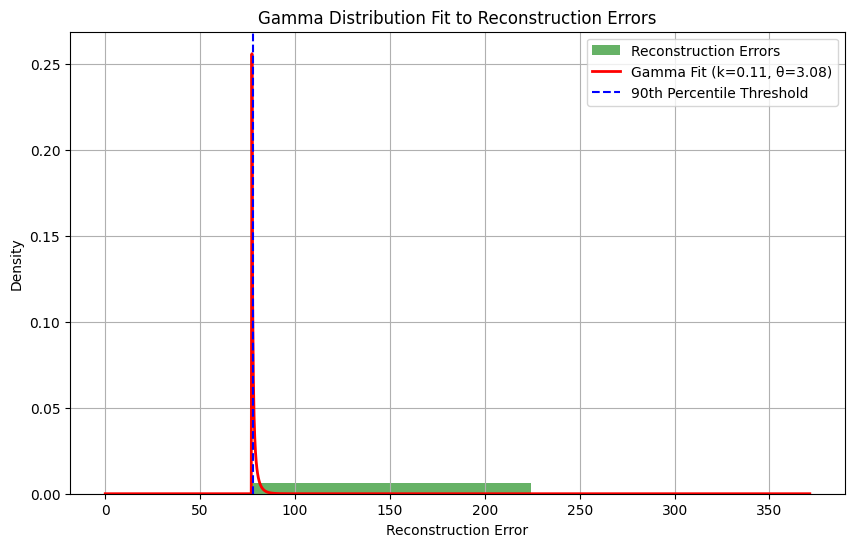

In [28]:
# Generate gamma distribution for visualization
x = np.linspace(0, max(values), 1000)
gamma_pdf = gamma.pdf(x, shape, loc=loc, scale=scale)

# Plot histogram and gamma distribution
plt.figure(figsize=(10, 6))
plt.hist(values, bins=2, density=True, alpha=0.6, color='g', label='Reconstruction Errors')
plt.plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma Fit (k={shape:.2f}, θ={scale:.2f})')
plt.axvline(gamma.ppf(0.90, shape, loc=loc, scale=scale), color='b', linestyle='--', label='90th Percentile Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Gamma Distribution Fit to Reconstruction Errors')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import re

status_list = []
pattern = r"_(normal|anomaly)_"

for line in testing_filenames:
    match = re.search(pattern, line)
    if match:
        status_list.append(match.group(1))

#print(len(status_list))
#status_list

In [30]:
# Convert to 1 for 'anomaly' and 0 for 'normal'
binary_labels = [1 if label == 'anomaly' else 0 for label in status_list]

print(binary_labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Confusion Matrix:
[[ 0  0]
 [ 2 68]]
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0286
Recall (Sensitivity): 0.9714
Specificity: 0.0000
Precision: 1.0000
F1-Score: 0.9855
Accuracy: 0.9714


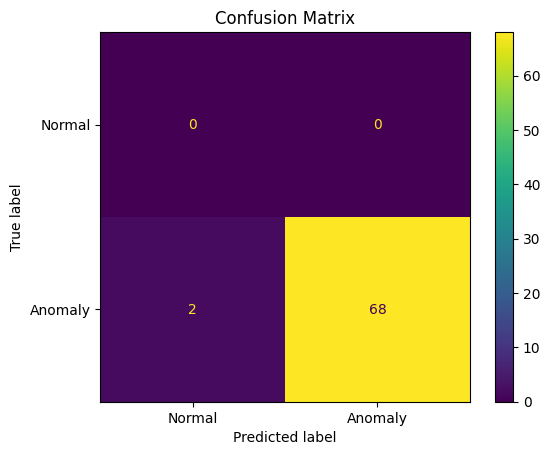

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(binary_labels, anomaly_labels.astype(int))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack values directly

# Calculate metrics
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Print results
print(f"Confusion Matrix:\n{cm}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()


AUC Score: nan (nan%)


d:\GitHub\MasterThesis\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


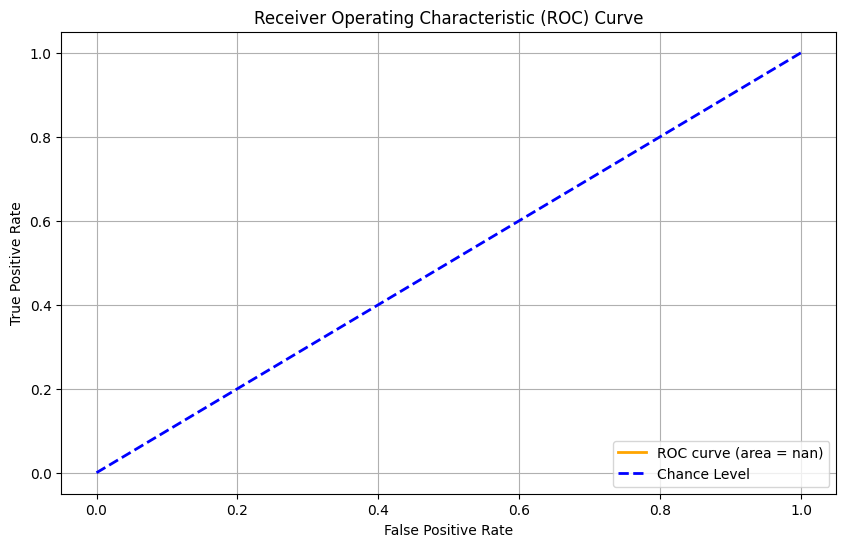

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming `values` contains the predicted scores for each sample (higher = more anomalous)
# `binary_labels` contains the true labels: 0 for Normal, 1 for Anomaly

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(binary_labels, values)  # Use raw scores for ROC computation

# Calculate the Area Under the Curve (AUC)
auc_score = auc(fpr, tpr)
print(f"AUC Score: {auc_score:.4f} ({auc_score*100:.0f}%)")

# Visualize the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

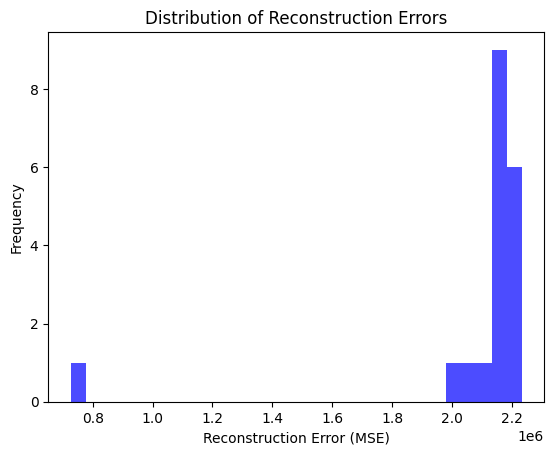

In [33]:
plt.hist(mse_list, bins=30, color='blue', alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.show()